In [83]:
from get_mnist_features import get_gp_mnist_data
from keras.datasets import mnist
import numpy as np
import scipy.io

from keras.utils import to_categorical
from keras import backend as K

from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [86]:
# %%time
# (mnist_train, X_train, y_train) ,(mnist_test, X_test, y_test) = get_gp_mnist_data('my_model.h5')
mnist_train = np.load('data/mnist_train.npy')
X_train = np.load('data/X_train.npy')
y_train = np.load('data/y_train.npy')

mnist_test = np.load('data/mnist_test.npy')
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')

(2, 128)
False


In [124]:
(mnist_train, y_train), (mnist_test, y_test) = mnist.load_data()

mnist_train = mnist_train.astype('float32')
mnist_train /= 255
mnist_test = mnist_test.astype('float32')
mnist_test /= 255

#Handle Theano and Tensorflow data format
img_rows, img_cols = 28,28

print("Image data format: {}".format(K.image_data_format()))

if K.image_data_format() == 'channel_first':
    mnist_train = mnist_train.reshape(mnist_train.shape[0], 1, img_rows, img_cols)
    mnist_test = mnist_test.reshape(mnist_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    mnist_train = mnist_train.reshape(mnist_train.shape[0], img_rows, img_cols, 1)
    mnist_test = mnist_test.reshape(mnist_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = get_gp_mnist_data('my_model.h5', mnist_train)
X_test = get_gp_mnist_data('my_model.h5', mnist_test)

Image data format: channels_last


In [126]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 128)
(60000,)
(10000, 128)
(10000,)


# Train a GP on the features

In [127]:
import gpflow
import tensorflow as tf

from sklearn.metrics import classification_report

from matplotlib import pyplot as plt

In [128]:
num_classes = 10
num_features = 128

In [129]:
%%time
X_train = X_train.astype('float64').reshape(-1,num_features)[:100]
y_train = y_train.astype('float64').reshape(-1,1)[:100]
kernel = gpflow.kernels.Matern32(num_features) + gpflow.kernels.White(num_features, variance=0.01)
likelihood = gpflow.likelihoods.MultiClass(num_classes)
Z=X_train[::5].copy()
num_latent=num_classes
whiten=True
q_diag=True
m = gpflow.models.SVGP(X_train, y_train, 
                       kern=kernel, 
                       likelihood=likelihood,
                       Z=Z, 
                       num_latent=num_latent,
                       whiten=whiten, 
                       q_diag=q_diag)

m.kern.white.variance.trainable = False
m.feature.trainable = False
m.as_pandas_table()

CPU times: user 6.13 s, sys: 126 ms, total: 6.25 s
Wall time: 6.27 s


In [130]:
%%time
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 181.408685
  Number of iterations: 430
  Number of functions evaluations: 461
CPU times: user 24.4 s, sys: 1.09 s, total: 25.5 s
Wall time: 14.9 s


In [131]:
%%time
X_test = X_test.astype('float64').reshape(-1,num_features)
print(X_test.shape)
p, var = m.predict_y(X_test)

(10000, 128)
CPU times: user 9.93 s, sys: 204 ms, total: 10.1 s
Wall time: 4.15 s


In [133]:
print(p)

[[5.02960579e-04 2.80773098e-04 5.78859711e-04 ... 9.95864386e-01
  1.37191959e-04 4.65607477e-04]
 [1.17888847e-01 2.05015637e-01 5.54519378e-01 ... 1.70934400e-02
  1.34243288e-02 3.32000458e-03]
 [4.30769868e-04 9.93699870e-01 5.43096884e-04 ... 9.60634160e-04
  3.84366619e-04 2.16496552e-04]
 ...
 [7.88156886e-04 1.05512535e-02 5.53965877e-04 ... 2.98003599e-03
  7.83300095e-03 1.95017843e-02]
 [8.82369605e-03 3.57805347e-03 1.42156159e-03 ... 3.14267685e-03
  2.29945098e-02 1.79625980e-02]
 [2.23199743e-03 7.16688679e-04 1.25470680e-03 ... 4.39776136e-04
  2.66057504e-04 3.74319595e-04]]


In [134]:
predictions = np.argmax(p, axis=-1)
accuracy = len(np.argwhere(predictions == y_test))/len(predictions)
print(accuracy)
print(classification_report(y_test, predictions))

0.9612
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       980
          1       0.95      1.00      0.97      1135
          2       1.00      0.91      0.95      1032
          3       0.99      0.99      0.99      1010
          4       0.98      0.99      0.98       982
          5       1.00      0.86      0.92       892
          6       0.96      0.99      0.97       958
          7       0.96      0.98      0.97      1028
          8       1.00      0.91      0.95       974
          9       0.86      0.99      0.92      1009

avg / total       0.96      0.96      0.96     10000



In [135]:
incorrect_indices = np.argwhere(predictions != y_test)
correct_indices = np.argwhere(predictions == y_test)
print(len(incorrect_indices))

388


[0.24538107 0.0209174  0.09439507 0.02358613 0.00745645 0.005549
 0.10242879 0.00211885 0.16866585 0.06528849]
Correct class: [8]


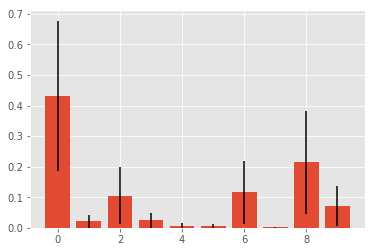

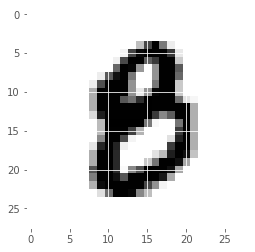

In [136]:
%matplotlib inline
index = incorrect_indices[5]
print(var[index].squeeze())
plt.bar(np.arange(10), p[index].squeeze(), yerr=var[index].squeeze())
print("Correct class: {}".format(y_test[index]))
plt.figure()
plt.imshow(mnist_test[index].reshape(28,28),cmap =plt.cm.gray_r, interpolation = "nearest") 

[5777]
[0.00382133 0.00631087 0.02604019 0.00235345 0.00499557 0.00953762
 0.01598742 0.00340596 0.88588116 0.04086743]
[0.00380673 0.00627105 0.0253621  0.00234791 0.00497062 0.00944666
 0.01573182 0.00339436 0.10109573 0.03919728]
Correct class: [8]


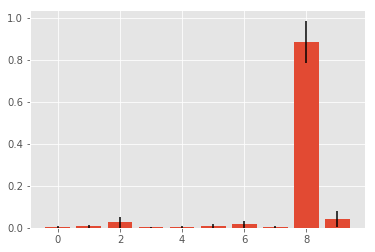

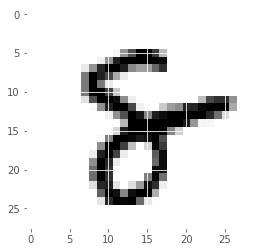

In [137]:
# %matplotlib inline
index = correct_indices[5496]
print(index)
print(p[index].squeeze())
print(var[index].squeeze())
plt.bar(np.arange(10), p[index].squeeze(), yerr=var[index].squeeze())
print("Correct class: {}".format(y_test[index]))
plt.figure()
plt.imshow(mnist_test[index].reshape(28,28),cmap =plt.cm.gray_r, interpolation = "nearest") 

## Noisy mnist

In [138]:
def load_data(DATA_DIR):
    rows, cols = 28, 28
    nb_classes = 10

    mat = scipy.io.loadmat(DATA_DIR)
    print(list(mat.keys()))
    X_train = mat['train_x']
    Y_train = np.argmax(mat['train_y'], axis=-1)
    X_test = mat['test_x']
    Y_test = np.argmax(mat['test_y'], axis=-1)
    
    # Reshape and format input
    
    #Renormalize images
    X_train = X_train.astype('float32')
    X_train /= 255.0
    X_test = X_test.astype('float32')
    X_test /= 255.0

    return (X_train, Y_train, X_test, Y_test)

(noisy_nmist_X_train, noisy_nmist_Y_train, noisy_nmist_X_test, noisy_nmist_Y_test) = load_data('data/mnist-with-awgn.mat')
(blur_nmist_X_train, blur_nmist_Y_train, blur_nmist_X_test, blur_nmist_Y_test) = load_data('data/mnist-with-motion-blur.mat')
(contrast_nmist_X_train, contrast_nmist_Y_train, contrast_nmist_X_test, contrast_nmist_Y_test) = load_data('data/mnist-with-reduced-contrast-and-awgn.mat')

['__header__', 'test_x', '__globals__', 'train_y', 'test_y', '__version__', 'train_x']
['__header__', 'test_x', '__globals__', 'train_y', 'test_y', '__version__', 'train_x']
['__header__', 'test_x', '__globals__', 'train_y', 'test_y', '__version__', 'train_x']


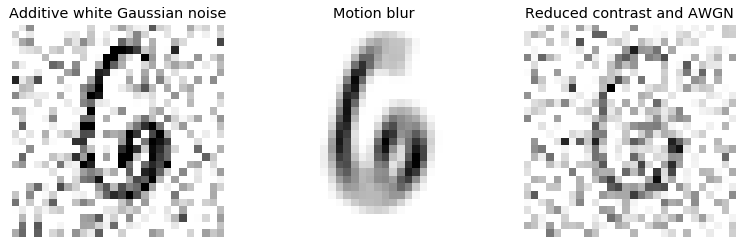

In [185]:
fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(1,3,1)

index=4

ax1.imshow(noisy_nmist_X_test[index].reshape(28,28),cmap =plt.cm.gray_r) 
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Additive white Gaussian noise")

ax2 = fig.add_subplot(1,3, 2)
ax2.imshow(blur_nmist_X_test[index].reshape(28,28),cmap =plt.cm.gray_r) 
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("Motion blur")

ax3 = fig.add_subplot(1,3, 3)
ax3.imshow(contrast_nmist_X_test[index].reshape(28,28),cmap =plt.cm.gray_r) 
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title("Reduced contrast and AWGN")

fig.savefig("figs/noisy_mnist_example.png", bbox_inches='tight')

## Use CNN to predict noisy training examples. Note that these are unseen although called 'training'

In [18]:
import keras

In [40]:
img_rows, img_cols = 28,28

model = keras.models.load_model('my_model.h5')

cnn_noisy_predictions_probas = model.predict(noisy_nmist_X_train.reshape(-1, img_rows, img_cols, 1))
cnn_noisy_predictions = np.argmax(cnn_noisy_predictions_probas, axis=-1)

cnn_blur_predictions_probas = model.predict(blur_nmist_X_train.reshape(-1, img_rows, img_cols, 1))
cnn_blur_predictions = np.argmax(cnn_blur_predictions_probas, axis=-1)

cnn_contrast_predictions_probas = model.predict(contrast_nmist_X_train.reshape(-1, img_rows, img_cols, 1))
cnn_contrast_predictions = np.argmax(cnn_contrast_predictions_probas, axis=-1)

In [172]:
noisy_accuracy = len(np.argwhere(cnn_noisy_predictions == noisy_nmist_Y_train))/len(noisy_nmist_Y_train)
print(noisy_accuracy)

blur_accuracy = len(np.argwhere(cnn_blur_predictions == blur_nmist_Y_train))/len(blur_nmist_Y_train)
print(blur_accuracy)

noisy_accuracy = len(np.argwhere(cnn_contrast_predictions == contrast_nmist_Y_train))/len(contrast_nmist_Y_train)
print(noisy_accuracy)

0.9435333333333333
0.9326833333333333
0.7770666666666667


## Use GP to predict noisy training examples

In [42]:
%%time

# noisy_X_train = get_gp_mnist_data('my_model.h5', noisy_nmist_X_train.reshape(-1, img_rows, img_cols, 1))
# blur_X_train = get_gp_mnist_data('my_model.h5', blur_nmist_X_train.reshape(-1, img_rows, img_cols, 1))
# contrast_X_train = get_gp_mnist_data('my_model.h5', contrast_nmist_X_train.reshape(-1, img_rows, img_cols, 1))

noisy_X_train = np.load('data/noisy_X_train.npy')
blur_X_train = np.load('data/blur_X_train.npy')
contrast_X_train = np.load('data/contrast_X_train.npy')


CPU times: user 4.88 ms, sys: 228 ms, total: 232 ms
Wall time: 244 ms


In [43]:
noisy_X_train = noisy_X_train.astype('float64').reshape(-1,num_features)
noisy_probas, noisy_var = m.predict_y(noisy_X_train)
noisy_predictions = np.argmax(noisy_probas, axis=-1)

blur_X_train = blur_X_train.astype('float64').reshape(-1,num_features)
blur_probas, blur_var = m.predict_y(blur_X_train)
blur_predictions = np.argmax(blur_probas, axis=-1)

contrast_X_train = contrast_X_train.astype('float64').reshape(-1,num_features)
contrast_probas, contrast_var = m.predict_y(contrast_X_train)
contrast_predictions = np.argmax(contrast_probas, axis=-1)

In [44]:
noisy_accuracy = len(np.argwhere(noisy_predictions == noisy_nmist_Y_train))/len(noisy_nmist_Y_train)
blur_accuracy = len(np.argwhere(blur_predictions == blur_nmist_Y_train))/len(blur_nmist_Y_train)
contrast_accuracy = len(np.argwhere(contrast_predictions == contrast_nmist_Y_train))/len(contrast_nmist_Y_train)
print(noisy_accuracy)
print(blur_accuracy)
print(contrast_accuracy)

0.2104
0.6075666666666667
0.2104


In [171]:
%matplotlib inline
def draw_img(img, axes,title=""):
    axes.imshow(img.reshape(28,28),cmap =plt.cm.gray_r) 
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_title(title)
    
def draw_probs(prob, var=None, axes=None):
    axes.bar(np.arange(10), prob, yerr=var)
    axes.set_ylim([0,1])
    axes.set_xticks(np.arange(10))
#     axes.set_xlabel("Digit")
    
def plot_noisy_example(img_index):
    fig = plt.figure(figsize=(12,10))

    draw_img(noisy_nmist_X_train[img_index], fig.add_subplot(3,3,1), title="White noise")
    draw_probs(noisy_probas[img_index], noisy_var[img_index], axes=fig.add_subplot(3,3,2)) 
    draw_probs(cnn_noisy_predictions_probas[img_index], axes=fig.add_subplot(3,3,3)) 

    draw_img(blur_nmist_X_train[img_index], fig.add_subplot(3,3,4), title="Motion blur")
    draw_probs(blur_probas[img_index], blur_var[img_index], axes=fig.add_subplot(3,3,5)) 
    draw_probs(cnn_blur_predictions_probas[img_index], axes=fig.add_subplot(3,3,6)) 
    
    draw_img(contrast_nmist_X_train[img_index], fig.add_subplot(3,3,7), title="White noise + reduced contrast")
    draw_probs(contrast_probas[img_index], contrast_var[img_index], fig.add_subplot(3,3,8)) 
    draw_probs(cnn_contrast_predictions_probas[img_index], axes=fig.add_subplot(3,3,9)) 
    
# img_index=1100
# plot_noisy_example(img_index)

(47376, 1)
(12624, 1)
Index: 0
Correct class: 4


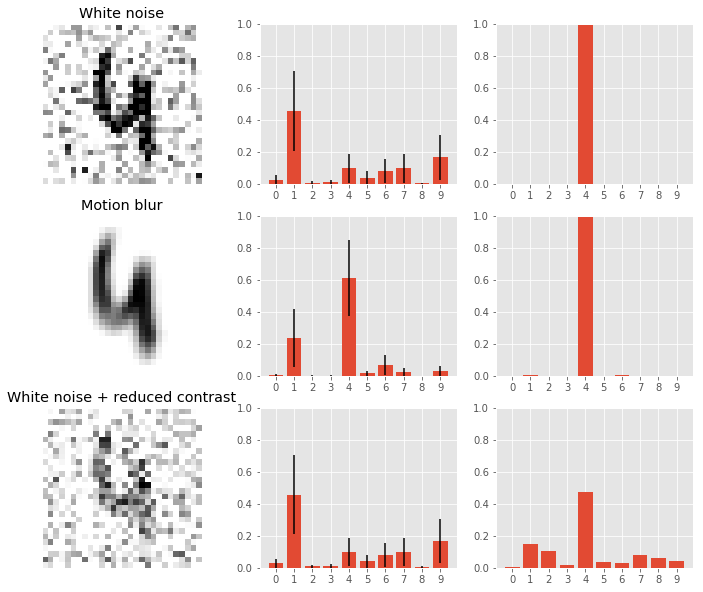

In [46]:
incorrect_indices = np.argwhere(noisy_predictions != noisy_nmist_Y_train)
correct_indices = np.argwhere(noisy_predictions == noisy_nmist_Y_train)
print(incorrect_indices.shape)
print(correct_indices.shape)
img_index = incorrect_indices[0][0]
print("Index: {}".format(img_index))
print("Correct class: {}".format(noisy_nmist_Y_train[img_index]))
plot_noisy_example(img_index)

Instead of accuracy use correct prediction score:
- 1 if correct prediction
- 0 if NN says "I don't know"
- -1 if incorrect

1. Eyeball
2. Invent metric
3. Embed in end-to-end system

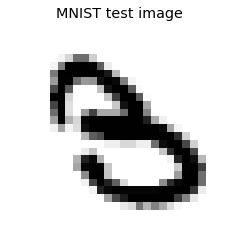

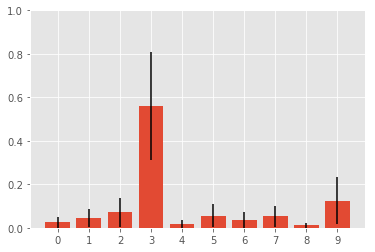

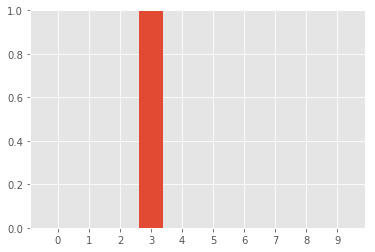

In [140]:
fig = plt.figure()
test_index = 18
cnn_pred = model.predict(np.array([mnist_test[test_index]]))[0]
draw_img(mnist_test[test_index], fig.add_subplot(1,1,1), title="MNIST test image")
fig.savefig("figs/mnist_test.png", bbox_inches="tight")
fig = plt.figure()
draw_probs(p[test_index], var[test_index], axes=fig.add_subplot(1,1,1)) 
fig.savefig("figs/gp_test.png", bbox_inches="tight")
fig = plt.figure()
draw_probs(cnn_pred, axes=fig.add_subplot(1,1,1)) 
fig.savefig("figs/cnn_test.png", bbox_inches="tight")